# Programm zur Erkennung von Hunderassen

## Schritt 1: Daten laden und Aufteilen in Trainings- und Testdaten

In [1]:
# Importieren der notwendigen Bibliotheken
import os
import numpy as np
import xml.etree.ElementTree as ET
from skimage import io, color, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [2]:
def read_images_to_split(dataset_path, annotation_path):
    # Funktion zum Parsen der Annotationsdateien
    def parse_annotation(xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        bndboxes = []
        for obj in root.findall('object'):
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
            bndboxes.append((xmin, ymin, xmax, ymax))
        return bndboxes

    # Laden der Bilder und Extrahieren der Hundebereiche
    images = []
    labels = []
    breeds = os.listdir(dataset_path)

    for breed in breeds:
        breed_img_path = os.path.join(dataset_path, breed)
        breed_anno_path = os.path.join(annotation_path, breed)
        if os.path.isdir(breed_img_path):
            for img_name in os.listdir(breed_img_path):
                img_path = os.path.join(breed_img_path, img_name)
                annotation_name = os.path.splitext(img_name)[0]
                annotation_file = os.path.join(breed_anno_path, annotation_name)
                if not os.path.exists(annotation_file):
                    continue  # Überspringe Bilder ohne Annotation
                image = io.imread(img_path)
                if image is None:
                    continue
                bndboxes = parse_annotation(annotation_file)
                for bndbox in bndboxes:
                    xmin, ymin, xmax, ymax = bndbox
                    xmin = max(0, xmin)
                    ymin = max(0, ymin)
                    xmax = min(image.shape[1], xmax)
                    ymax = min(image.shape[0], ymax)
                    if xmin >= xmax or ymin >= ymax:
                        continue  # Ungültige Bounding Box überspringen
                    cropped_image = image[ymin:ymax, xmin:xmax]
                    cropped_image = transform.resize(cropped_image, (256, 256))
                    images.append(cropped_image)
                    labels.append(breed)

    # Umwandeln der Labels in numerische Werte
    le = LabelEncoder()
    y = le.fit_transform(labels)

    # Konvertierung der Labels in One-Hot-Encoding
    y = to_categorical(y, 5)


    # Überprüfen, ob Bilder geladen wurden
    if len(images) == 0:
        print("Fehler: Keine Bilder geladen. Bitte überprüfen Sie den Pfad und die Annotationsdateien.")
    else:
        # Aufteilen in Trainings- und Testdaten
        X_train_img, X_test_img, y_train, y_test = train_test_split(images, y, test_size=0.25, stratify=y, random_state=42)

    return np.array(X_train_img), np.array(X_test_img), y_train, y_test, le


In [3]:
X_train_img, X_test_img, y_train, y_test, le = read_images_to_split("dogs", "annotations")

In [4]:
y_train

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]])

In [5]:
# Überprüfen der Anzahl der geladenen Bilder
print(f'Anzahl der Trainingsbilder: {len(X_train_img)}')
print(f'Anzahl der Testbilder: {len(X_test_img)}')


Anzahl der Trainingsbilder: 771
Anzahl der Testbilder: 258


## 2. Schritt: Netzarchitektur festlegen

Convolutional Neural Networks (CNNs) eignen sich hervorragend für Bildklassifikationsaufgaben, da sie räumliche Strukturen in Bildern effektiv erkennen können. CNNs verwenden Faltungsoperationen, die es ihnen ermöglichen, lokale Merkmale wie Kanten, Texturen und Formen zu extrahieren, die für die Unterscheidung von Hunderassen essenziell sind.

**Gründe für die Wahl von CNNs:**

1. Parameterreduzierung: Durch Gewichtsteilung reduzieren CNNs die Anzahl der zu lernenden Parameter im Vergleich zu vollständig verbundenen Netzwerken. Dies ist insbesondere bei großen Eingabebildern (z. B. 256x256) wichtig.
2. Translation Invariance: CNNs können wichtige Merkmale unabhängig von deren Position im Bild erkennen, was bei der Hunderassenerkennung hilfreich ist, da die Hunde in unterschiedlichen Posen und Perspektiven dargestellt sein können.
3. Hierarchisches Lernen: CNNs lernen in den unteren Schichten einfache Merkmale (wie Kanten) und kombinieren diese in höheren Schichten zu komplexeren Merkmalen (z. B. Gesichtszüge von Hunden).

**Netzwerkarchitektur:**
Für die Hunderassenerkennung wähle ich folgende Architektur:

- *Eingabeschicht*: Input-Shape (256, 256, 3) (RGB-Bilder mit Größe 256x256).
- *Faltungsschichten (Convolutional Layers)*: Mehrere Schichten mit 3x3-Filtern und zunehmender Filteranzahl (z. B. 32, 64, 128), um unterschiedliche Merkmale zu extrahieren.
- *Pooling-Schichten (MaxPooling)*: Nach jeder Faltungsschicht zur Reduktion der räumlichen Dimension und zur Verhinderung von Überanpassung.
- *Batch-Normalisierung*: Um die Trainingsstabilität zu erhöhen und den Gradientenfluss zu verbessern.
- *Dropout*: Nach den Faltungsblöcken, um Überanpassung zu reduzieren.
- *Fully-Connected Layer*: Eine oder mehrere vollständig verbundene Schichten, um die gelernte Merkmalsrepräsentation in Klassen zu übersetzen.
- *Ausgabeschicht*: Softmax-Aktivierung mit so vielen Neuronen wie Hunderassenklassen.

## 3. Schritt: Netzarchitektur implementieren

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# Netzwerkarchitektur
model = Sequential([
    # Input layer
    Input(shape=(256, 256, 3)),
    
    # Faltungsschicht 1
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    # Add other layers as needed

    # Faltungsschicht 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Faltungsschicht 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Übergang zu Fully-Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    # Ausgabeschicht
    Dense(5, activation='softmax')
])

# Netzwerkübersicht anzeigen
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,586,885 (112.87 MB)

 Trainable params: 29,586,437 (112.86 MB)

 Non-trainable params: 448 (1.75 KB)

## 4. Schritt: Wahl einer geeigneten Lossfunktion und eines Optimizers

**Loss-Funktion:** CategoricalCrossentropy <br>
Diese Funktion eignet sich für Multi-Klassen-Klassifikationsprobleme und misst die Divergenz zwischen den vorhergesagten Wahrscheinlichkeiten und den tatsächlichen Klassenlabels.

**Optimizer:** Adam <br>
Der Adam-Optimizer kombiniert die Vorteile von AdaGrad und RMSProp und passt die Lernrate für jeden Parameter dynamisch an. Er ist robust und effizient, besonders bei großen Datenmengen und komplexen Modellen.

In [7]:
# Kompilierung des Modells
model.compile(
    optimizer=Adam(learning_rate=0.001), # Die Learning Rate wird hier zur Standard Rate gesetzt um später den Unterschied besser sichtbar zu machen
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 5. Evaluation mit der Kreuzvalidierung

In [8]:
# Kreuzvalidierung (3-fold)
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold = 1
conf_matrices = []
all_y_true = []
all_y_pred = []

for train_idx, val_idx in kf.split(X_train_img):
    print(f"Fold {fold}:")
    X_train_fold, X_val_fold =np.array(X_train_img)[train_idx], np.array(X_train_img)[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    
    # Training
    model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
              epochs=30, batch_size=16, verbose=1)
    
    # Evaluation
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Speichern der Labels für den Report
    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_pred_classes)

    conf_matrices.append(confusion_matrix(y_val_fold, y_pred_classes))
    fold += 1


# Classification Report
print("\nClassification Report (Gesamtergebnis aus allen Folds):\n")
print(classification_report(all_y_true, all_y_pred, target_names=le.classes_))

# Mittelwert der Konfusionsmatrizen berechnen
avg_conf_matrix = np.mean(conf_matrices, axis=0)

# Visualisierung der Konfusionsmatrix
disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf_matrix, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Durchschnittliche Konfusionsmatrix")
plt.show()


Fold 1:
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.3290 - loss: 44.6587 - val_accuracy: 0.3424 - val_loss: 23.7548
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - accuracy: 0.5877 - loss: 23.1471 - val_accuracy: 0.1751 - val_loss: 104.9828
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.6387 - loss: 9.2109 - val_accuracy: 0.2062 - val_loss: 114.3673
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.6235 - loss: 4.7272 - val_accuracy: 0.2724 - val_loss: 88.1482
Epoch 5/30
 6/33 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.6613 - loss: 2.0363

KeyboardInterrupt: 

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step - accuracy: 0.5656 - loss: 2.8021 - val_accuracy: 0.2946 - val_loss: 49.8679
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 312ms/step - accuracy: 0.5372 - loss: 1.3693 - val_accuracy: 0.3450 - val_loss: 24.8813
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 311ms/step - accuracy: 0.6302 - loss: 1.0213 - val_accuracy: 0.3372 - val_loss: 15.5703
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 309ms/step - accuracy: 0.6154 - loss: 0.9933 - val_accuracy: 0.4302 - val_loss: 8.3134
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - accuracy: 0.6503 - loss: 0.9891 - val_accuracy: 0.5000 - val_loss: 5.9296
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 312ms/step - accuracy: 0.6455 - loss: 1.0970 - val_accuracy: 0.5078 - val_loss: 5.7297
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - accuracy: 0.6509 - loss: 1.2853 - val_accuracy: 0.5271 - val_loss: 5.3351
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 317ms/step - accuracy: 0.6771 - loss: 1.0164 - val_a

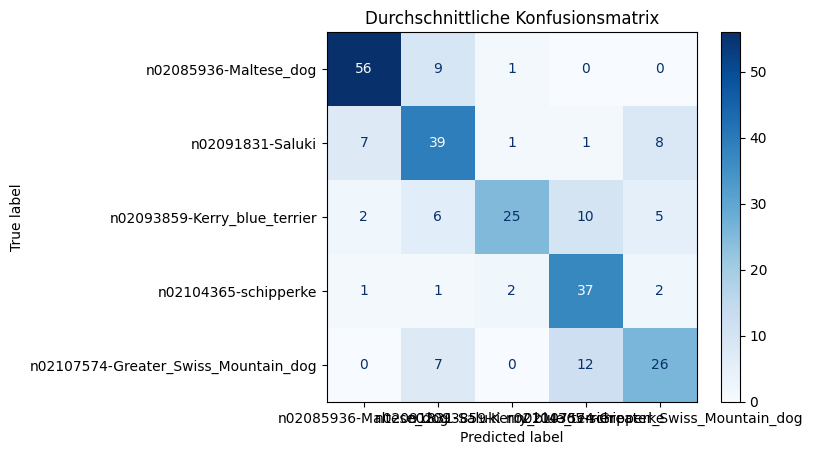

In [9]:
X_train_img, X_test_img, y_train, y_test, le = read_images_to_split("dogs", "annotations")

# Training
model.fit(X_train_img, y_train, validation_data=(X_test_img, y_test),
            epochs=30, batch_size=16, verbose=1)

# Vorhersagen für X_test_img
y_test_pred = model.predict(X_test_img)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# Visualisierung der Konfusionsmatrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_int, y_test_pred_classes), display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Durchschnittliche Konfusionsmatrix")

y_test_pred_classes = to_categorical(y_test_pred_classes)

report = classification_report(y_test, y_test_pred_classes, target_names=le.classes_)

# Ausgabe des Reports
print("Classification Report:")
print(report)
plt.show()

## 6. Transfer Learning

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import copy

# Entfernen der letzten drei Schichten und Hinzufügen neuer Schichten

new_model = copy.deepcopy(model)

new_model.pop()
new_model.pop()
new_model.pop()

# Hinzufügen neuer Schichten
new_model.add(Dense(256, activation='relu', name="new_dense"))
new_model.add(Dropout(0.5, name="new_dropout"))
new_model.add(Dense(5, activation='softmax', name="new_output"))


# Gefrorene Schichten (bis zur neuen Dense-Schicht)
for layer in new_model.layers[:-3]:  # Alle außer den neuen Schichten einfrieren
    layer.trainable = False

# Kompilieren des neuen Modells
new_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Überblick über das neue Modell
#new_model.summary()

X_train_new, X_test_new, y_train_new, y_test_new, le_new = read_images_to_split("dogs_extended", "annotations")

# Early Stopping für schnelles Training
#early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Training der neuen Ausgabeschicht
new_model.fit(
    X_train_new, y_train_new,
    validation_data=(X_test_new, y_test_new),
    epochs=30, batch_size=16
)

# Feinabstimmung des gesamten Modells
for layer in new_model.layers:
    layer.trainable = True  # Alle Schichten freigeben

# Reduzierte Lernrate für Fine-Tuning
new_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

new_model.fit(
    X_train_new, y_train_new,
    validation_data=(X_test_new, y_test_new),
    epochs=5, batch_size=32
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.3365 - loss: 29.0555 - val_accuracy: 0.4662 - val_loss: 7.7145
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.5594 - loss: 2.9148 - val_accuracy: 0.4511 - val_loss: 4.6404
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.5910 - loss: 1.5487 - val_accuracy: 0.4699 - val_loss: 3.8630
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.5969 - loss: 1.5256 - val_accuracy: 0.4812 - val_loss: 3.0650
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.6383 - loss: 1.4882 - val_accuracy: 0.4135 - val_loss: 4.3163
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.6383 - loss: 1.3452 - val_accuracy: 0.4925 - val_loss: 3.3691
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.6432 - loss: 1.3384 - val_accuracy: 0.5263 - val_loss: 3.0735
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6526 - loss: 1.0427 - val_accuracy: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
                               precision    recall  f1-score   support

       n02088094-Afghan_hound       0.66      0.79      0.72        72
   n02089973-English_foxhound       0.69      0.63      0.66        49
 n02096294-Australian_terrier       0.75      0.59      0.66        51
   n02113978-Mexican_hairless       0.54      0.61      0.57        41
n02116738-African_hunting_dog       0.60      0.55      0.57        53

                     accuracy                           0.65       266
                    macro avg       0.65      0.63      0.64       266
                 weighted avg       0.65      0.65      0.64       266



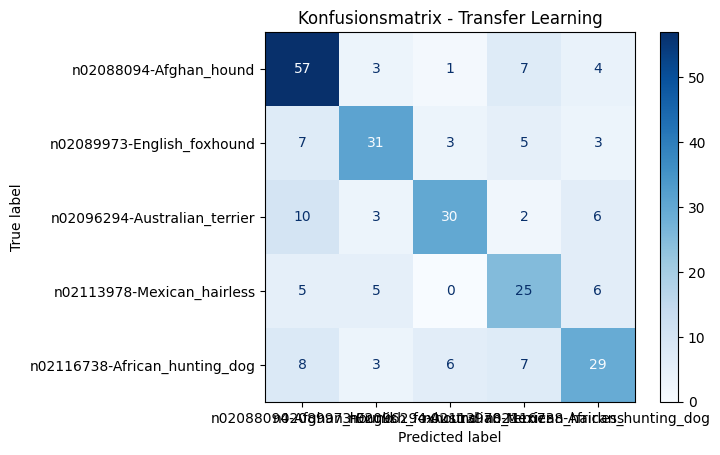

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Vorhersagen für Testdaten
y_pred_new = new_model.predict(X_test_new)

# Konvertiere die Vorhersagen zu Klassenindizes
y_pred_classes_new = np.argmax(y_pred_new, axis=1)
y_test_int_new = np.argmax(y_test_new, axis=1)

# Konfusionsmatrix
conf_matrix_new = confusion_matrix(y_test_int_new, y_pred_classes_new)
disp_new = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_new, display_labels=le_new.classes_)
disp_new.plot(cmap=plt.cm.Blues)
plt.title("Konfusionsmatrix - Transfer Learning")

#y_pred_classes_new = to_categorical(y_pred_classes_new)

#y_pred_classes_new = to_categorical(y_pred_classes_new)
report = classification_report(y_test_int_new, y_pred_classes_new, target_names=le_new.classes_)

print(report)


#plt.show()